In [1]:
import numpy as np
from numpy import percentile
from numpy import mean
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from functools import reduce
from itertools import combinations
import itertools


def cluster_comb(dataset):
    cluster_groups = []
    # Name of Cluster___ within the dataset column
    cl_sections = sorted([i for i in dataset.columns if 'Cluster' in i])

    #Number of clusters within each cluster sections
    comb_list = [dataset[i].unique() for i in dataset.columns if 'Cluster' in i]
    comb_list = [j for i in comb_list for j in i]

    #Finding total combinations for clusters
    combinations = sorted(list(dict.fromkeys(itertools.combinations(comb_list,3))))

    for i in combinations:
        cluster_groups.append(dataset[ (dataset[cl_sections[0]] == i[0]) & (dataset[cl_sections[1]] == i[1]) & (dataset[cl_sections[2]] == i[2])])
    
    return cluster_groups
  
def select_features(X, y):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit_transform(X, y)
    return fs
  
#Feature selection from each cluster combination
def feat_select(dataset):    
    
    X = dataset.drop(columns=['index','Cluster','Cluster_v','Cluster_c','bichoice'])
    y = dataset['bichoice']
    
    fs = select_features(X,y)
    
    #creating a dictionary for feature selection score on each feature
    feat = {}
    for i in range(len(fs.scores_)): # Feature score is based on chi-square
        feat[i] = fs.scores_[i]
    
    #sorting the dictionary based on the value (not Key)
    # Here the Key is the Score from feature selection and Value is the location of that feature (1st ,2nd 3rd...)
    sorted_key = sorted(feat.items(),reverse=True, key=lambda kv: kv[1])    
    
    #Selecting the top 5 Features (highest score selected)
    top5 = sorted_key[:5]
    
    #From top 5, get the keys (nth feature)
    li = [] # this list contains the location of top 5 features
    for i in top5:
        li.append(i[0])
    
    feat_s = X[X.columns[li]].reset_index() #Selecting the nth feature from the X dataframe 
    bi = y.reset_index()
    
    clustering_comb = pd.merge(feat_s,bi) #Merge with the Outcome an return the dataframe having Top5 features + Outcome
    
    return clustering_comb
  
def looping (cluster_group):
    #looping all the cluster (27) select feature and retun the dataframe with only top 5 features (total output number is 27)
    cluster_comb = [] #This list will contain the Dataframe obtained from feat_select function for all 27 combinations
    for i in cluster_group:
        cluster_comb.append(feat_select(i))
    return cluster_comb

# Getting the probabilities Matrix used for Naive Bayes formula 
def probability (dataset): #Dataframe inserted here will be the cluster_comb[:]
    
    li = []
    # Loop through columns obtained from cluster_comb list (above)
    for features in dataset.columns[1:-1]: # Top 5 Feature names selected
        for i in dataset[features].value_counts().keys(): #get the classes within each feature(Ex, Range: 100 200 300 400)
            
            #Ex. P(Xn|Y) = P(Range = 30,000 | Bichoice = 1) = Total # of Range = 30,000 where bichoice = 1/ Total # bichoice = 1
            #Ex. For Cluster_comb[0], that is Cluster 0-0-0, The Total Sample Size is 751 -> 400 for y=1 and 351 for y=0
            # These values witll be the Denominator, Numerator will be depending on the Specific Class with a certain Feature
            p = dataset[dataset[features] == i]['bichoice'].value_counts()/dataset['bichoice'].value_counts()
            p = p.to_frame().reset_index()
            p.rename(columns={'bichoice': '{} {}'.format(features,i) },inplace=True)
            li.append(p)

    data_frames = li[:]
    result = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, 
                                              left_index=True, on=['index'],#right_index=True,
                                              how='outer'),data_frames)
    result.drop(['index'],axis=1,inplace=True)
    result.fillna(0,inplace=True)
    
    return result

  
# Dataframe: one out of 27 Cluster combination
# Prior: The percentange calculated from the Dataframe (1/27 Cluster comb)
# y: Defining whether we would like to see the probabilities of bichoce 0 or 1
def Naive_bayes(dataset,likelihood_matrix,y):
    
    numerator = [] #bichoice = 0: P(Xn|Y=0).... *P(Y=0)
    denominator = []# P(Xn|not y = 1)P(not y =1)
    
    for i in range(len(dataset)):
        likelihood = 1
        likelihood_not = 1
        for key,val in dict(dataset.iloc[i,1:-1]).items():
            match = '{} {}'.format(key,val)
            if match in likelihood_matrix.columns:
                
                probability = likelihood_matrix[match][y]
                likelihood = likelihood * probability
                prior = len(dataset[dataset.bichoice == y]/ len(dataset))
                
                pxn_ynot = likelihood_matrix[match][(y -1) * -1]
                likelihood_not = likelihood_not * pxn_ynot
                prior_not = len(dataset[dataset.bichoice == (y-1) * -1]/ len(dataset))
            
        numerator.append(likelihood * prior)
        denominator.append(likelihood_not*prior_not)

    # P(Xn|y)p(y) + P(Xn|not y)P(not y) = Denominator (evidence)
    denominator = [(i+j) for i,j in zip(numerator,denominator)] 

    total = [int((numer/denomi)*100) for numer,denomi in zip(numerator, denominator)] #Numerator/ Denominator
    total = [0 if i ==100 else i for i in total]
    
    return total
  
def nb_loop(cluster_comb):
    #Running all of 27 cluster combination with generated functions to get the final result as probability 
    bayes_proba = []# The list contains all the probabilities calculated for each samples in each 27 clusters combination 
    for i in cluster_comb: #27 Combination in a list format
        pr = probability(i)
        bayes_proba.append(Naive_bayes(i,pr,0)) # Compute Naive Bayes Algorithm and add to the list 
    return bayes_proba 

  
# Finding the Minimum and Maximum Probability obtained from each Cluster
def min_max (nb_prob):
    min_max = []
    for cluster_comb in nb_prob:
        mean = np.mean(cluster_comb)
        for sample in range(len(cluster_comb)):
            if cluster_comb[sample] == 0:
                cluster_comb[sample] = mean
        min_max.append([min(cluster_comb),np.where(np.array(cluster_comb)==min(cluster_comb))[0][0],
                                       max(cluster_comb),np.where(np.array(cluster_comb)==max(cluster_comb))[0][0]])
    return min_max

  
def prob_seperation(nb_prob, cluster_comb):
    high = [] #High probability of buychoice being 0 -> Not willing to buy Electric vehicle with given conditions
    low = [] #Lower probability of buychoice being 0 -> Higher willingness to buy Electric vehicles with given conditions 
    for i in range(len(nb_prob)):
            high.append([index for index, prob in enumerate(nb_prob[i]) if prob > 75])
            low.append([index for index, prob in enumerate(nb_prob[i]) if prob < 25])
            
    high_group = [] # For Each Cluster, High Probability of Bichoice 0 is gathered -> Meaning Low probability of bichoice 1
    lower_group = [] # For Each Cluster, Low Probability of Bichoice 0 is gathered -> Meaning High Probability of bichoice 1
    for i in range(len(high)):
        a = high[i]
        high_group.append(cluster_comb[i].iloc[[*a]])

    for j in range(len(low)):
        b = low[j]
        lower_group.append(cluster_comb[j].iloc[[*b]])
    
    return high_group, lower_group

# Naive Bayes Algorithm

## Importing Data

In [2]:
final = pd.read_csv('customer.csv')
final.drop(columns = ['Unnamed: 0'], inplace = True)

In [3]:
final

,index,gender,state_answer,hsincome,age,work_parking,Cluster,dmileage,long_dist,gascost,Cluster_v,home_chg,work_chg,fasttime,town,Cluster_c,range,numprice,priceshow,bichoice
0,0,0,44,2,3,4,2,25,1,1,1,0,0,15,2,0,100,10000,7000,1
1,1,0,44,2,3,4,2,25,1,1,1,20,3,15,3,1,400,10000,7000,0
2,2,0,44,2,3,4,2,25,1,1,1,0,10,30,3,1,200,10000,7000,1
3,3,0,44,2,3,4,2,25,1,1,1,0,10,5,3,0,300,10000,8500,1
4,4,0,44,2,3,4,2,25,1,1,1,20,20,30,3,1,100,10000,7000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,5797,1,9,5,2,2,1,10,0,1,2,1,3,30,1,1,300,40000,40000,0
5798,5798,1,9,5,2,2,1,10,0,1,2,0,1,15,3,0,400,40000,40000,0
5799,5799,1,9,5,2,2,1,10,0,1,2,20,5,15,1,1,200,40000,28000,0
5800,5800,1,9,5,2,2,1,10,0,1,2,10,10,5,4,0,300,40000,40000,0


## Cluster Combination

The function splits the dataset (including all the sample - 5802) into 27 different cluster combinations
<br>
We have sepearted features into the relevant category (3 intotal feature groups)
1. Socio-Economic
2. Individual Behavior towards automotive
3. Charging Infrastructure

<br>
K-Mode sepearted each of the groups into 3 total clusters and therefore the possible combinations are
<br>
3 x 3 x 3 = 27

In [4]:
cluster_combination = cluster_comb(final)

In [5]:
# Represents the first cluster combination out of 27 (0 - 0 - 0)
cluster_combination[0]

,index,gender,state_answer,hsincome,age,work_parking,Cluster,dmileage,long_dist,gascost,Cluster_v,home_chg,work_chg,fasttime,town,Cluster_c,range,numprice,priceshow,bichoice
6,6,1,11,3,3,2,0,25,2,1,0,3,2,15,1,0,300,15000,12750,0
9,9,1,11,3,3,2,0,25,2,1,0,3,1,5,4,0,400,15000,12750,1
79,79,1,41,3,2,2,0,10,2,3,0,1,20,5,3,0,200,20000,17000,0
80,80,1,41,3,2,2,0,10,2,3,0,2,2,30,4,0,200,20000,17000,1
81,81,1,41,3,2,2,0,10,2,3,0,5,2,5,3,0,100,20000,14000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5737,5737,1,20,3,2,2,0,15,2,3,0,0,20,30,1,0,400,25000,25000,1
5740,5740,1,20,3,2,2,0,15,2,3,0,20,2,15,2,0,400,25000,17500,0
5741,5741,1,20,3,2,2,0,15,2,3,0,0,3,60,2,0,200,25000,17500,1
5762,5762,0,20,5,1,2,0,50,3,3,0,5,3,30,2,0,400,20000,14000,0


Feature will be selected to reduce the dimension (avoid curse of dimensionality)

feat_select(cluster_combination[0])

In [6]:
# Looping function works to loop all the 27 clusters
dim_reduced = looping(cluster_combination)

In [7]:
dim_reduced[0]

,index,numprice,range,home_chg,priceshow,fasttime,bichoice
0,6,15000,300,3,12750,15,0
1,9,15000,400,3,12750,5,1
2,79,20000,200,1,17000,5,0
3,80,20000,200,2,17000,30,1
4,81,20000,100,5,14000,5,1
...,...,...,...,...,...,...,...
746,5737,25000,400,0,25000,30,1
747,5740,25000,400,20,17500,15,0
748,5741,25000,200,0,17500,60,1
749,5762,20000,400,5,14000,30,0


# Naive Bayes - Probability

Naive Bayes algorithm has probability calculation to be done
<br>
We want to caclulate the probability of each feature given Y = 0 or 1

In [8]:
probability(dim_reduced[0])

,numprice 30000,numprice 20000,numprice 25000,numprice 10000,numprice 40000,numprice 15000,numprice 50000,numprice 5000,range 100,range 300,...,priceshow 42500,priceshow 50000,priceshow 35000,priceshow 3500,priceshow 4250,priceshow 5000,fasttime 5,fasttime 15,fasttime 30,fasttime 60
0,0.239316,0.202279,0.125356,0.119658,0.096866,0.096866,0.062678,0.05698,0.339031,0.222222,...,0.022792,0.019943,0.019943,0.019943,0.017094,0.019943,0.447293,0.242165,0.139601,0.17094
1,0.180000,0.155000,0.167500,0.160000,0.147500,0.090000,0.072500,0.02750,0.192500,0.280000,...,0.030000,0.022500,0.020000,0.012500,0.010000,0.005000,0.445000,0.265000,0.160000,0.13000


Computing Navie Bayes with the given probability Matrix and Samples

In [9]:
# Output represents the Probability calculated for each sample with given features
Naive_bayes(dim_reduced[0], probability(dim_reduced[0]), 1)[:5]

[59, 62, 40, 46, 28]

In [10]:
nb = nb_loop(dim_reduced)

Discovering the Maximum and Minimum probability obtained

In [11]:
# [Lowest Probability of 5% , on Index 243 (sample Number for tracking purpose), Highest Probability of 93%, on Index 709] 
# 5% probability of having buy choice of 0 (index 242)
# 93% probability of having buy choice of 0 (index 709)
min_max(nb)[0]

[5, 242, 93, 709]

Probability near 50% will not be a great candidate and want to find out the sample with the high and low probability of choosing Y = 0 or 1, that way we can visualize their preference towards vehicle purchase

In [12]:
h, l = prob_seperation(nb,dim_reduced)

### Evaluation - Accuracy

In [204]:
result = []
for i in range(len(nb)):
    a = [0 if prob >= 50 else 1 for prob in nb[i]]
    result.append(a)

In [205]:
percentage = []
for i in range(len(nb)):
    count = 0
    for y , pred in zip(dim_reduced[i]['bichoice'].values, result[i]):
        if y == pred:
            count = count + 1
        avg = count / len(result[i])
    percentage.append(avg)

In [210]:
for i in range(len(percentage)):
    print('Accuracy Rate of Cluster Combination {} is {}%'.format(i, round(percentage[i] * 100,2)))

Accuracy Rate of Cluster Combination 0 is 65.51%
Accuracy Rate of Cluster Combination 1 is 41.72%
Accuracy Rate of Cluster Combination 2 is 66.8%
Accuracy Rate of Cluster Combination 3 is 67.11%
Accuracy Rate of Cluster Combination 4 is 46.73%
Accuracy Rate of Cluster Combination 5 is 67.06%
Accuracy Rate of Cluster Combination 6 is 29.8%
Accuracy Rate of Cluster Combination 7 is 70.67%
Accuracy Rate of Cluster Combination 8 is 61.54%
Accuracy Rate of Cluster Combination 9 is 31.89%
Accuracy Rate of Cluster Combination 10 is 72.76%
Accuracy Rate of Cluster Combination 11 is 37.78%
Accuracy Rate of Cluster Combination 12 is 36.05%
Accuracy Rate of Cluster Combination 13 is 69.75%
Accuracy Rate of Cluster Combination 14 is 57.66%
Accuracy Rate of Cluster Combination 15 is 32.26%
Accuracy Rate of Cluster Combination 16 is 72.82%
Accuracy Rate of Cluster Combination 17 is 43.48%
Accuracy Rate of Cluster Combination 18 is 33.59%
Accuracy Rate of Cluster Combination 19 is 64.68%
Accuracy Rat

In [13]:
#Indicating the Selected Samples that are most likely to select EV as their buychoice
h[0]

,index,numprice,range,home_chg,priceshow,fasttime,bichoice
17,129,30000,100,20,21000,5,0
25,256,20000,100,5,20000,5,1
29,284,5000,200,10,5000,15,0
37,347,10000,200,10,10000,5,0
41,374,10000,100,0,10000,30,0
...,...,...,...,...,...,...,...
688,5318,20000,100,0,17000,60,1
695,5375,15000,200,20,15000,60,0
709,5473,5000,200,10,5000,5,0
710,5474,5000,400,0,5000,5,0


In [215]:
#Indicating the Seelcted samples that are not likely to select EV as their buy choice 
l[0]

,index,numprice,range,home_chg,priceshow,fasttime,bichoice
6,96,40000,300,1,34000,5,1
8,100,40000,300,3,34000,15,1
20,188,25000,300,3,21250,30,1
33,342,10000,300,20,8500,5,1
36,345,10000,400,3,7000,5,1
...,...,...,...,...,...,...,...
718,5491,15000,300,2,10500,5,1
729,5589,40000,300,3,34000,15,1
739,5714,40000,100,1,28000,15,1
745,5736,25000,400,5,17500,15,1


## Visualizing the Distribution

In [223]:
info_range =[]
info_price = []
info_budget = []
for i in range(len(l)):
    try:
        info_range.append(l[i]['range'].to_frame())
        info_price.append(l[i]['priceshow'].to_frame())
        info_budget.append(l[i]['numprice'].to_frame())
    except:
        break

Text(0, 0.5, 'Frequency')

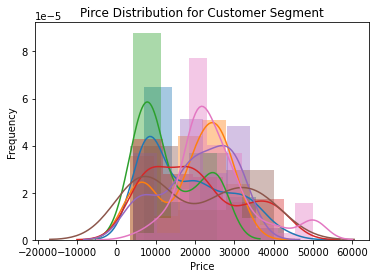

In [231]:
for i in info_price:
    sns.distplot(i)
plt.title('Pirce Distribution for Customer Segment')
plt.xlabel('Price')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

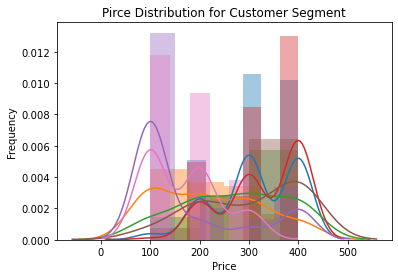

In [232]:
for i in info_range:
    sns.distplot(i)
plt.title('Pirce Distribution for Customer Segment')
plt.xlabel('Price')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

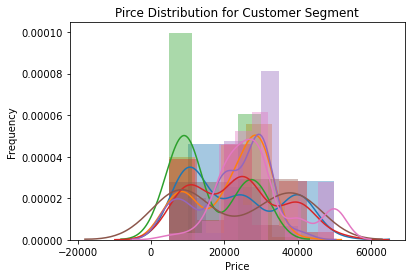

In [233]:
for i in info_budget:
    sns.distplot(i)
plt.title('Pirce Distribution for Customer Segment')
plt.xlabel('Price')
plt.ylabel('Frequency')

As the distrubution plot indicates, cluster combinations indeed have different form of distribution

## Hypothesis Testing

In order to check the difference in the distribution, Kruskal Hypothesis testing was done

In [235]:
from scipy.stats import kruskal #one way Non-parametric ANOVA 
stat, p = kruskal(*info_range)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('The same distribution')
else:
    print('Different distributions')

stat=175.749, p=0.000
Different distributions


In [236]:
stat, p = kruskal(*info_price)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('The same distribution')
else:
    print('Different distributions')

stat=38.211, p=0.000
Different distributions


In [237]:
stat, p = kruskal(*info_budget)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('The same distribution')
else:
    print('Different distributions')

stat=36.765, p=0.000
Different distributions


# Conclusion
* Customers were segemented based on their Characteristics: Socieconomic background, Electric Vehicle Charging Infrastructure, Vehicle Usage Behavior
* Identified total of 27 Different Segments related to Customer's information -> Computation was done to analyze what would be the contributing factors for their purchase decison (Either Electric Vehicle or Gasoline based)
* Instead of using the library, we have mannually created a function that calculates Naive Bayes Classifier, This method allows us to visualize the specific condition. 
* Extraction of samples from each clusters were made that had the highest percentage of the buy choice being Purchasing of the Electric vehicle.
* We have identified that those high percentage groups were having specific characteristics in terms of their features
* Hypothesis testing was done to verify that each cluster had different preference towards their buying choice 